# Residential Building Classification
This is a bare-bone version of the residential vs. non-residential building classification. We use DenseNet in this implementation. 

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

import numpy as np
import cv2
import matplotlib.pyplot as plt

from cs231n.data_utils import *
from sampler import RandomSampler
import params

# Load parameters
params = vars(params)
rbc_class_names = params['rbc_class_names']
fmow_class_names = params['fmow_class_names']
fmow_class_names_mini = params['fmow_class_names_mini']
dtype = params['dtype']

torch.set_num_threads(params['num_threads'])

## Preprocess FMOW Dataset
Check if fMoW dataset is available. If so, process the images by cropping based on given bounding boxes. Load in traing, validation and test dataset along with ground truth labels for training and validation set. 

In [2]:
# Load in training, validation and test data at once
mini_batch = 100 #1500
data = load_mini_fmow(params, batch_size=mini_batch)

HBox(children=(IntProgress(value=0, max=20), HTML(value='')))

Extracting images from airport_hangar...
Extracting images from barn...
Extracting images from educational_institution...
Extracting images from electric_substation...
Extracting images from factory_or_powerplant...
Extracting images from fire_station...
Extracting images from ground_transportation_station...
Extracting images from hospital...
Extracting images from lighthouse...
Extracting images from military_facility...
Extracting images from multi-unit_residential...
Extracting images from office_building...
Extracting images from parking_lot_or_garage...
Extracting images from place_of_worship...
Extracting images from police_station...
Extracting images from prison...
Extracting images from recreational_facility...
Extracting images from single-unit_residential...
Extracting images from space_facility...
Extracting images from tower...



In [3]:
# Split total data into training, validation and test groups
X_train = data['X_train']
y_train = data['y_train']
X_train_tensor = torch.from_numpy(X_train)
y_train_tensor = torch.from_numpy(y_train)
train_data = TensorDataset(X_train_tensor, y_train_tensor)
loader_train = DataLoader(train_data, batch_size=params['batch_size'], sampler=RandomSampler(X_train.shape[0]))

X_val = data['X_val']
y_val = data['y_val']
X_val_tensor = torch.from_numpy(X_val)
y_val_tensor = torch.from_numpy(y_val)
val_data = TensorDataset(X_val_tensor, y_val_tensor)
loader_val = DataLoader(val_data, batch_size=params['batch_size'], sampler=RandomSampler(X_val.shape[0]))

X_test = data['X_test']
y_test = data['y_test']
X_test_tensor = torch.from_numpy(X_test)
y_test_tensor = torch.from_numpy(y_test)
test_data = TensorDataset(X_test_tensor, y_test_tensor)
loader_test = DataLoader(test_data, batch_size=params['batch_size'], sampler=RandomSampler(X_test.shape[0]))

# Print out all the keys and values from the data dictionary
for k, v in data.items():
    print(k, type(v), v.shape, v.dtype)


X_train <class 'numpy.ndarray'> (80, 1, 200, 200) float32
y_train <class 'numpy.ndarray'> (80,) int32
X_val <class 'numpy.ndarray'> (10, 1, 200, 200) float32
y_val <class 'numpy.ndarray'> (10,) int32
X_test <class 'numpy.ndarray'> (10, 1, 200, 200) float32
y_test <class 'numpy.ndarray'> (10,) int32
mean_image <class 'numpy.ndarray'> (1, 200, 200) float32


In [4]:
mean_image = data['mean_image']
data_test = load_test(params, mean_image)
X_test = data_test['X_test']
y_test = data_test['y_test']
X_test_tensor = torch.from_numpy(X_test)
y_test_tensor = torch.from_numpy(y_test)
test_data = TensorDataset(X_test_tensor, y_test_tensor)
loader_test = DataLoader(test_data, batch_size=params['batch_size'], sampler=RandomSampler(X_test.shape[0]))
print(X_test.shape, X_test.dtype)
print(y_test.shape, y_test.dtype)
print(y_test)

Extracting Test Images...
(12, 1, 200, 200) float32
(12,) int32
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


### Visualize a small batch of data
Plot a small batch of training images to get a sense of data

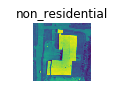

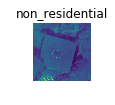

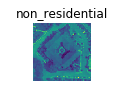

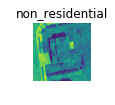

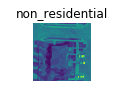

In [5]:
# Sample a minibatch and show the images and captions
mini_size = 5
indices = np.random.choice(X_test.shape[0], mini_size, replace=False)
for i, idx in enumerate(indices):
    plt.subplot(1, mini_size, i+1)
    img = np.moveaxis(X_test[idx, :, :, :], 0, -1)
    plt.imshow(img[:,:,0])
    plt.axis('off')
    plt.title(rbc_class_names[y_test[idx]])
    plt.show()

## Load Model
Load in pre-trained DenseNet. Configure training parameters. 

### Naive two-layer CNN

In [18]:
# CNN Model (3 conv layer)
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=6, stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.fc = nn.Linear(12*12*32, len(rbc_class_names))
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out
    
#     200*200  
#     98*98
#     49*49
#     24*24
#     12*12
#     11111---1

In [19]:
# Params
num_epochs = params['num_epochs']
learning_rate = params['learning_rate']
print_every = params['print_every']

model = CNN().type(dtype)
model.load_state_dict(torch.load('cnn.pkl'))
loss_fn = nn.CrossEntropyLoss().type(dtype)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_history = []
train_acc_history = []
val_acc_history = []

## Train Model
Train the model one epoch at a time. Keep the verbose option on to monitor the loss during training. 
Save training and validation accuracy history for visualization. 

In [32]:
# Define Train function
def train(model, loss_fn, optimizer, loader_train, loader_val, epochs=1):
    for epoch in range(epochs):
        # Set on Training mode
        model.train()
        for t, (x, y) in enumerate(loader_train):
            x_var = Variable(x.type(dtype))
            y_var = Variable(y.type(dtype).long())
            scores = model(x_var)
            loss = loss_fn(scores, y_var)
            loss_history.append(loss.data[0])
            if (t + 1) % print_every == 0:
                print('t = %d, loss = %.4f' % (t + 1, loss.data[0]))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        train_acc_history.append(check_accuracy(model, loader_train))
        val_acc_history.append(check_accuracy(model, loader_val))
            
def check_accuracy(model, loader, num_limit=100):
    '''
    Returns:
    - acc: Scalar giving the fraction of instances that were correctly
      classified by the model.
    '''
    num_correct = 0
    num_samples = 0
    # Put model in test mode
    model.eval() 
    # Compute predictions in batches to save memory
    for x, y in loader:
        x_var = Variable(x.type(dtype), volatile=True) 
        scores = model(x_var)
        _, preds = scores.data.cpu().max(1)
        num_correct += (preds == y).sum()
        num_samples += preds.size(0)
        if num_samples >= num_limit:
            break
    acc = float(num_correct) / num_samples
    print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
    return acc
 

In [20]:
# Train the model
train(model, loss_fn, optimizer, loader_train, loader_val, epochs=num_epochs)

t = 10, loss = 0.7162
t = 20, loss = 0.6335
t = 30, loss = 0.5721
t = 10, loss = 0.6697
t = 20, loss = 0.5259
t = 30, loss = 0.5375
t = 10, loss = 0.5693
t = 20, loss = 0.5691
t = 30, loss = 0.6153
t = 10, loss = 0.5179
t = 20, loss = 0.5398
t = 30, loss = 0.4851
t = 10, loss = 0.4853
t = 20, loss = 0.5531
t = 30, loss = 0.5227
t = 10, loss = 0.4286
t = 20, loss = 0.4813
t = 30, loss = 0.5380
t = 10, loss = 0.3449
t = 20, loss = 0.5290
t = 30, loss = 0.5247
t = 10, loss = 0.4260
t = 20, loss = 0.4823
t = 30, loss = 0.4305
t = 10, loss = 0.4851
t = 20, loss = 0.3962
t = 30, loss = 0.4710
t = 10, loss = 0.3934
t = 20, loss = 0.3142
t = 30, loss = 0.4305
t = 10, loss = 0.4402
t = 20, loss = 0.4166
t = 30, loss = 0.3440
t = 10, loss = 0.3611
t = 20, loss = 0.4448
t = 30, loss = 0.3870
t = 10, loss = 0.4042
t = 20, loss = 0.4171
t = 30, loss = 0.4487
t = 10, loss = 0.3269
t = 20, loss = 0.3864
t = 30, loss = 0.2821
t = 10, loss = 0.3727
t = 20, loss = 0.3509
t = 30, loss = 0.4001
t = 10, lo

## Visualization
Visualize training and validation accuracy throughout training history. 
Visualize loss function. 

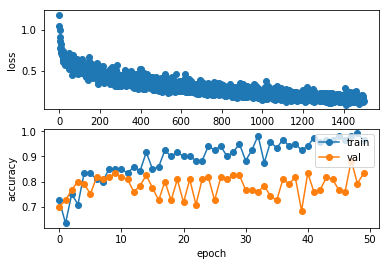

In [21]:
# Visualize loss history and training/validation accuracy history
plt.subplot(2, 1, 1)
plt.plot(loss_history, 'o')
plt.xlabel('iteration')
plt.ylabel('loss')

plt.subplot(2, 1, 2)
plt.plot(train_acc_history, '-o')
plt.plot(val_acc_history, '-o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

## Test Model
Make predictions based on test dataset. Visually assess the quality of prediction and compute accuracy based on groundtruth. 

In [33]:
# Check accuracy of model on Test set
test_acc = check_accuracy(model, loader_test)
print("Test Accuracy: %.3f" % test_acc)

Got 7 / 12 correct (58.33)
Test Accuracy: 0.583


### Visualize Successful and Failed Examples

In [63]:
x = np.array([[1,2],[2,3],[3,4]])
mask = [False,False,True]
print(x)

[[1 2]
 [2 3]
 [3 4]]


In [41]:
X_success = np.array([]).reshape((0, 1, 200, 200))
y_success = np.array([]).reshape((0,))
X_failure = np.array([]).reshape((0, 1, 200, 200))
y_failure = np.array([]).reshape((0,))

model.eval() 
for X, y in loader_test:
    X_var = Variable(X.type(dtype), volatile=True)
    scores = model(X_var)
    _, preds = scores.data.cpu().max(1)
    idx_success = (preds == y).numpy() == 1
    idx_failure = (preds != y).numpy() == 1
    X = X.numpy()
    y = y.numpy()
    X_success = np.append(X_success, X[idx_success.tolist(), :, :, :], axis=0)
    y_success = np.append(y_success, y[idx_success.tolist(), ], axis=0)
    X_failure = np.append(X_failure, X[idx_failure.tolist(), :, :, :], axis=0)
    y_failure = np.append(y_failure, preds[idx_failure.tolist(), ], axis=0)
    
y_success = y_success.astype(np.int32)
y_failure = y_failure.astype(np.int32)

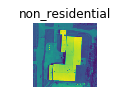

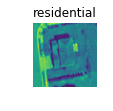

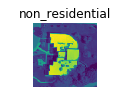

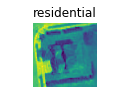

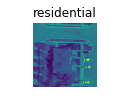

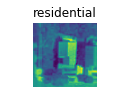

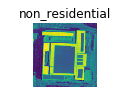

IndexError: index 7 is out of bounds for axis 0 with size 7

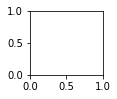

In [35]:
# Sample a batch of successfully classified images
for i in range(12):
    plt.subplot(3, 4, i+1)
    img = np.moveaxis(X_success[i, :, :, :], 0, -1)
    plt.imshow(img[:,:,0])
    plt.axis('off')
    plt.title(rbc_class_names[y_success[i]])
    plt.show()

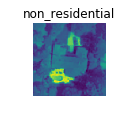

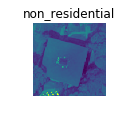

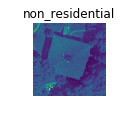

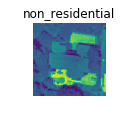

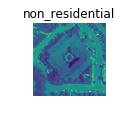

IndexError: index 5 is out of bounds for axis 0 with size 5

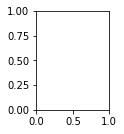

In [42]:
# Sample a batch of incorrectly classified images
plt.title('Failure Examples')
for i in range(8):
    plt.subplot(2, 4, i+1)
    img = np.moveaxis(X_failure[i, :, :, :], 0, -1)
    plt.imshow(img[:,:,0])
    plt.axis('off')
    plt.title(rbc_class_names[y_failure[i]])
    plt.show()

## Save Model

In [85]:
# Save the Trained Model
torch.save(model.state_dict(), 'cnn.pkl')